# Report02 - 泰坦尼克号的生存预测

* 沈键
* 2021200082


## 1. 任务简介

    泰坦尼克号沉船事故是世界上最著名的沉船事故之一。1912年4月15日，在她的处女航期间，泰坦尼克号撞上冰山后沉没，造成2224名乘客和机组人员中超过1502人的死亡。这一轰动的悲剧震惊了国际社会，并因此建立了更好的船舶安全法规。 事故中导致死亡的一个原因是许多船员和乘客没有足够的救生艇。然而在被获救群体中也有一些比较幸运的因素；一些人群在事故中被救的几率高于其他人，比如妇女、儿童和上层阶级。 这个任务中，我们需要分析和判断出什么样的人更容易获救，然后要利用机器学习来预测出在这场灾难中哪些人会最终获救。


## 2. 分析数据

    本次任务中，给了一个名为train.csv的数据集文件，里面有891名乘客的数据。首先，我们使用pandas读取该文件，查看有哪些变量。

In [1]:
import pandas as pd

train_df = pd.read_csv("./data/train.csv")
train_df.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

通过查看前几行，可以看到，每一行数据包括乘客的id、乘客等级、名字、性别、年龄、和该乘客一起旅行的兄弟姐妹和配偶的数量、和该乘客一起旅行的父母和孩子的数量、船票号、船票价格、船舱号、登船港口(S=英国南安普顿Southampton(起航点)/C=法国 瑟堡市Cherbourg(途经点)/Q=爱尔兰 昆士Queenstown(途经点))以及该乘客对应的最终是否存活。通过观察各列数据，还可以看出，某些列上存在缺失值，pandas带入数据集文件后，缺失值处会显示为NaN。通过热力图，可以更加直观的展示缺失值的分布情况。

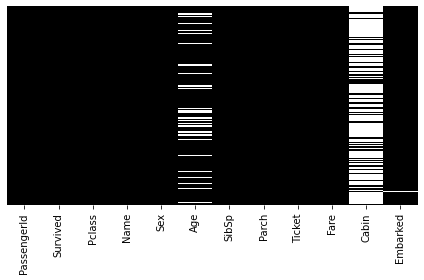

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='CMRmap')
plt.tight_layout() 
plt.show()

通过将缺失值处的位置通过热力图高亮显示，可以看到，年龄(Age)、船舱号(Cabin)和登船港口(Embarked)列存在缺失值，并且，年龄和船舱号的缺失值很多。

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


年龄列的缺失率为(891-714)/891\*100%=19.9%, 船舱号列的缺失率为(891-204)/891\*100%=77.1%, 登船港口列的缺失率为(891-889)/891\*100%=0.2%。可以看出船舱号列的缺失率很高，所以我们将其忽略，同时，乘客id和船票号意义不大，我们也将其忽略。接下里，我们分别研究其余因素对获救率的影响。

In [4]:
train_df.drop('PassengerId', axis=1, inplace=True)
train_df.drop('Ticket', axis=1, inplace=True)
train_df.drop('Cabin', axis=1, inplace=True)

### 2.1 乘客等级对获救率的影响

<Figure size 432x288 with 0 Axes>

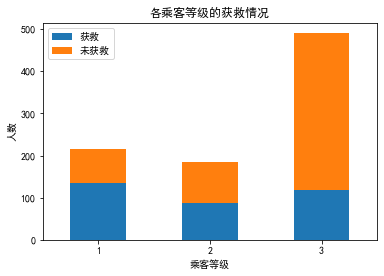

In [5]:
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

fig = plt.figure()
fig.set(alpha=0.2)

Suvived_0 = train_df.Pclass[train_df.Survived == 0].value_counts()
Suvived_1 = train_df.Pclass[train_df.Survived == 1].value_counts()
df = pd.DataFrame({u"获救": Suvived_1, u"未获救": Suvived_0})
df.plot(kind='bar', stacked=True)
plt.xticks(rotation=360)
plt.title(u'各乘客等级的获救情况')
plt.xlabel(u'乘客等级')
plt.ylabel(u'人数')
plt.show()

可以看到，乘客等级为1的获救率最高，乘客等级为2的次之，乘客等级为3的获救率最低。显然，富人的获救率比穷人的获救率更高，且等级高的对应舱的救援设备一般都会好于等级低的船舱。

### 2.2 名字对获救率的影响

观察乘客名字列，可以发现，乘客名字的中间部分对应了乘客目前的社会头衔或者已婚情况。

In [6]:
import re

def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return

titles = train_df["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Countess      1
Lady          1
Mme           1
Jonkheer      1
Don           1
Ms            1
Capt          1
Sir           1
Name: Name, dtype: int64


例如Miss表示未婚的女士，而Mrs为已婚的女士，Capt、Col、Major、Dr、Rev头衔的可认为是政府官员，Don、Sir、Countess、Lady头衔的可认为是皇室成员，Master和Jonkheer表示有技能的人，如果出现其他头衔，则分到Others类。

In [7]:
# 将Name列改名为Title
train_df.rename(columns={'Name':'Title'}, inplace=True)
train_df['Title'] = train_df['Title'].apply(get_title)
title_classification = {'Officer':['Capt', 'Col', 'Major', 'Dr', 'Rev'],
                       'Royalty':['Don', 'Sir', 'Countess', 'Lady'],
                       'Mrs':['Mme', 'Ms', 'Mrs'],
                       'Miss':['Mlle', 'Miss'],
                       'Mr':['Mr'],
                       'Master':['Master','Jonkheer']}
title_map = {}
for title in title_classification.keys():
    title_map.update(dict.fromkeys(title_classification[title], title))

train_df['Title'] = train_df['Title'].map(title_map)

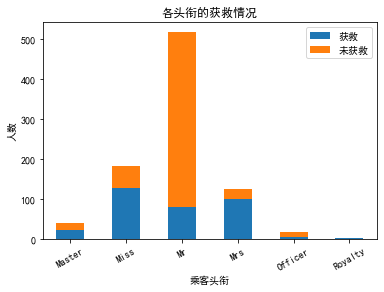

In [8]:
Suvived_0 = train_df.Title[train_df.Survived == 0].value_counts()
Suvived_1 = train_df.Title[train_df.Survived == 1].value_counts()
df = pd.DataFrame({u"获救": Suvived_1, u"未获救": Suvived_0})
df.plot(kind='bar', stacked=True)
plt.xticks(rotation=30)
plt.title(u'各头衔的获救情况')
plt.xlabel(u'乘客头衔')
plt.ylabel(u'人数')
plt.show()

可以看到，不同头衔对应的获救情况不同，其中，已婚女士和未婚女士的获救率较高，而男士的获救率较低，这与社会上提倡女士优先有着密切的关系，同时，
皇室和有技能的人的获救率也很高，这与他们的社会地位有关，社会地位高的人往往会被优先救援。



In [9]:
train_df.head(10)

Survived  Pclass   Title     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3      Mr    male  22.0      1      0   7.2500        S
1         1       1     Mrs  female  38.0      1      0  71.2833        C
2         1       3    Miss  female  26.0      0      0   7.9250        S
3         1       1     Mrs  female  35.0      1      0  53.1000        S
4         0       3      Mr    male  35.0      0      0   8.0500        S
5         0       3      Mr    male   NaN      0      0   8.4583        Q
6         0       1      Mr    male  54.0      0      0  51.8625        S
7         0       3  Master    male   2.0      3      1  21.0750        S
8         1       3     Mrs  female  27.0      0      2  11.1333        S
9         1       2     Mrs  female  14.0      1      0  30.0708        C

### 2.3 性别对获救率的影响

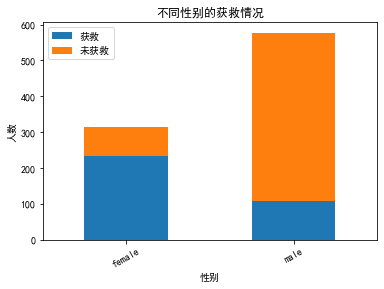

In [10]:
Suvived_0 = train_df.Sex[train_df.Survived == 0].value_counts()
Suvived_1 = train_df.Sex[train_df.Survived == 1].value_counts()
df = pd.DataFrame({u"获救": Suvived_1, u"未获救": Suvived_0})
df.plot(kind='bar', stacked=True)
plt.xticks(rotation=30)
plt.title(u'不同性别的获救情况')
plt.xlabel(u'性别')
plt.ylabel(u'人数')
plt.show()

如同在头衔分析中提到的一样，女士的获救率高于男士，与社会上提倡女士优先有着密切的关系。

## 2.4 年龄对获救率的影响

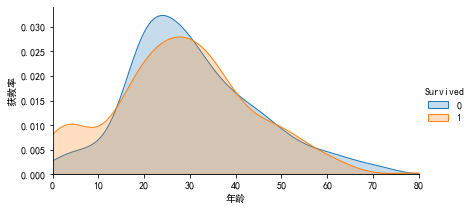

In [11]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()
plt.xlabel(u'年龄') 
plt.ylabel(u'获救率') 
plt.show()

从上图中可以看出，年龄(<=15)小存活率高，年龄大(>=60)的存活率低，这与社会对小孩的保护以及老年人体力不行有关。

### 2.5 家庭成员数量对获救率的影响

家庭成员包括一起旅行的兄弟姐妹和配偶的数量以及一起旅行的父母和孩子的数量。

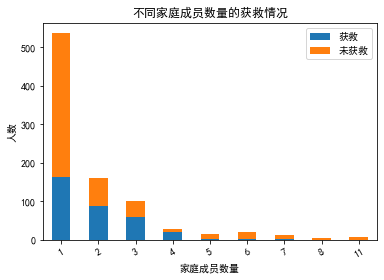

In [12]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
Suvived_0 = train_df.FamilySize[train_df.Survived == 0].value_counts()
Suvived_1 = train_df.FamilySize[train_df.Survived == 1].value_counts()
df = pd.DataFrame({u"获救": Suvived_1, u"未获救": Suvived_0})
df.plot(kind='bar', stacked=True)
plt.xticks(rotation=30)
plt.title(u'不同家庭成员数量的获救情况')
plt.xlabel(u'家庭成员数量')
plt.ylabel(u'人数')
plt.show()

plt.show()

In [13]:
train_df.drop('SibSp', axis=1, inplace=True)
train_df.drop('Parch', axis=1, inplace=True)

船上家庭成员在3~4个左右的获救率最高，家庭成员太少或太多存活率都不高。一般而言，一个家庭里的成员会优先救自己本家庭中的人，但如果家庭人员太多，也会出现耽误了太多时间救援家庭成员而导致自己未及时离开的问题。

### 2.6 票价对获救率的影响

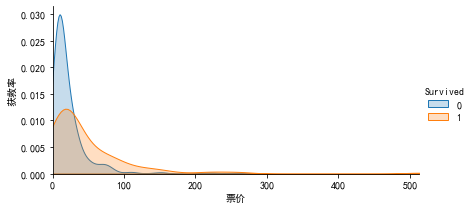

In [14]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train_df['Fare'].max()))
facet.add_legend()
plt.xlabel(u'票价') 
plt.ylabel(u'获救率') 
plt.show()

一般而言，票价高的往往位置比较好，救援设施也更好，获救率也越高。

### 2.7 登船港口对获救率的影响

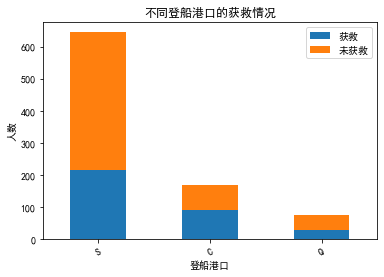

In [15]:
Suvived_0 = train_df.Embarked[train_df.Survived == 0].value_counts()
Suvived_1 = train_df.Embarked[train_df.Survived == 1].value_counts()
df = pd.DataFrame({u"获救": Suvived_1, u"未获救": Suvived_0})
df.plot(kind='bar', stacked=True)
plt.xticks(rotation=30)
plt.title(u'不同登船港口的获救情况')
plt.xlabel(u'登船港口')
plt.ylabel(u'人数')
plt.show()

船港口不同，生存率不同。在C港口上船的获救率最高，而在S港口上船的获救率最低。

### 3. 逻辑回归模型

    这是一个二分类问题，可以使用逻辑回归模型进行学习和预测。线性模型假设输出值与输入值之间满足：

$$ Y=X \times W^T + b $$

其中，$Y$为输出值，$X$为输入特征量，$W$为输入特征量的权重系数矩阵，$b$为偏置项。

当系数矩阵$W$和偏置项$b$确定后，输入一个特征向量，即可计算出一个值。但这样获得值是连续的，可能很大，也可能会很小，而分类范围，需要在[0,1]，逻辑回归就是一种减小预测范围，将预测值限定为[0,1]间的一种回归模型，其回归方程与回归曲线如下图所示。逻辑曲线在z=0时，十分敏感，在z>>0或z<<0处，都不敏感，将预测值限定为(0,1)。常用的逻辑回归函数为Sigmoid函数，其表达式为：

$$
g(z)=\frac{1}{1+e^{-z}}
$$

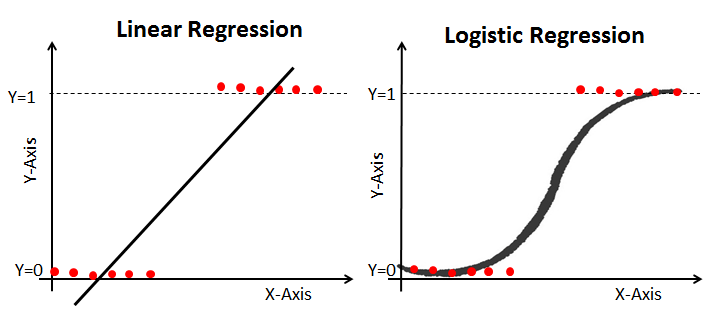

接着，再通过定义一个损失函数来描述预测值与真实值之间的误差，当预测值与真实值之间的误差越大时，损失函数也越大，通过梯度下降法可以得到系数矩阵和偏置项的优化趋势，再设立合适的学习率迭代求解，可得到对应较小损失函数值下的系数矩阵和偏置项的值，模型训练结束。

## 4. 模型训练

## 4.1 处理缺失值

&ensp;&ensp;&ensp;&ensp;目前的数据中，剔除船舱号后，年龄列和和登船港口列存在缺失值，需要进行补充。对于年龄，可以采用使用平均年龄进行填充，而对于登船港口，可以使用人数最多的登船港口(S)进行填充。此外，由于年龄是一个一个的数字，在数据量不够大的情况，这样一个一个的数字没太大意义，我们要按照年龄段进行划分，票价也是如此。

In [16]:
def handle_age(age):
    if age <= 15:
        return 0
    elif age <= 60:
        return 1
    else:
        return 2
    
def handle_fare(fare):
    if fare <= 32:
        return 0
    elif fare <= 100:
        return 1
    elif fare <= 200:
        return 2
    else:
        return 3
    
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean()).map(handle_age)
train_df['Embarked'] = train_df['Embarked'].fillna('S')
train_df['Fare'] = train_df['Fare'].map(handle_fare)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Survived    891 non-null    int64 
 1   Pclass      891 non-null    int64 
 2   Title       891 non-null    object
 3   Sex         891 non-null    object
 4   Age         891 non-null    int64 
 5   Fare        891 non-null    int64 
 6   Embarked    891 non-null    object
 7   FamilySize  891 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 55.8+ KB


In [18]:
train_df.head()

Survived  Pclass Title     Sex  Age  Fare Embarked  FamilySize
0         0       3    Mr    male    1     0        S           2
1         1       1   Mrs  female    1     1        C           2
2         1       3  Miss  female    1     0        S           1
3         1       1   Mrs  female    1     1        S           2
4         0       3    Mr    male    1     0        S           1

### 4.2 数字化数据

   当前的数据集还还不能直接进行训练，因为数据集中部分列是由字符串表示的，无法参与到数值运算过程中，因此，我们需要将字符串处理成数字的形式。

In [19]:
train_df.head()

Survived  Pclass Title     Sex  Age  Fare Embarked  FamilySize
0         0       3    Mr    male    1     0        S           2
1         1       1   Mrs  female    1     1        C           2
2         1       3  Miss  female    1     0        S           1
3         1       1   Mrs  female    1     1        S           2
4         0       3    Mr    male    1     0        S           1

在头衔对获救率影响的分析中，我们将头衔分类成了'Officer', 'Royalty', 'Mrs', 'Miss', 'Mr', 'Master'，使用数字1-6分别表示上述类别。

In [20]:
title_map2num = {'Officer': 1, 'Royalty': 2, 'Mrs': 3, 'Miss': 4, 'Mr':5, 'Master': 6}
train_df['Title'] = train_df['Title'].map(title_map2num)

In [21]:
train_df.head()

Survived  Pclass  Title     Sex  Age  Fare Embarked  FamilySize
0         0       3      5    male    1     0        S           2
1         1       1      3  female    1     1        C           2
2         1       3      4  female    1     0        S           1
3         1       1      3  female    1     1        S           2
4         0       3      5    male    1     0        S           1

对于性别这列，将female映射为0, male映射为1。

In [22]:
sex_map2num = {'female': 0, 'male': 1}
train_df['Sex'] = train_df['Sex'].map(sex_map2num)

In [23]:
train_df.head()

Survived  Pclass  Title  Sex  Age  Fare Embarked  FamilySize
0         0       3      5    1    1     0        S           2
1         1       1      3    0    1     1        C           2
2         1       3      4    0    1     0        S           1
3         1       1      3    0    1     1        S           2
4         0       3      5    1    1     0        S           1

将三个登船港口分别映射为0, 1, 2。

In [24]:
embarked_map2num = {'S': 0, 'C': 1, 'Q': 2}
train_df['Embarked'] = train_df['Embarked'].map(embarked_map2num)

In [25]:
train_df.head()

Survived  Pclass  Title  Sex  Age  Fare  Embarked  FamilySize
0         0       3      5    1    1     0         0           2
1         1       1      3    0    1     1         1           2
2         1       3      4    0    1     0         0           1
3         1       1      3    0    1     1         0           2
4         0       3      5    1    1     0         0           1

### 4.3 使用Pytorch搭建逻辑回归模型

In [26]:
import logging
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

class Titanic_Model(nn.Module):
  def __init__(self, input_dim, num_classes):
    super().__init__()
    self.input_dim   = input_dim
    self.num_classes = num_classes

    self.linear_layer = nn.Linear(input_dim, num_classes)

  def forward(self, inputs):
    outputs = self.linear_layer(inputs)
    return outputs

  @staticmethod
  def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  @staticmethod
  def log_epoch_loss_and_acc(prefix, epoch, epoch_loss, epoch_acc, interval=5):
    if epoch % interval == 0:
      logging.info(f'{prefix}_Epoch [{epoch}], loss: {epoch_loss:.4f},'
                   f' acc: {epoch_acc:.4f}.')

  def evaluate(self, batch, loss_func, need_acc=False, no_grad=False):
    if no_grad:
      with torch.no_grad():
        inputs, labels = batch
        outputs = self(inputs)
        loss = loss_func(outputs, labels)
    else:
      inputs, labels = batch
      outputs = self(inputs)
      loss = loss_func(outputs, labels)

    if need_acc:
      acc  = self.compute_accuracy(outputs, labels)
      return {'loss': loss, 'acc': acc}
    else:
      return {'loss': loss}

  def compute_epoch_loss_and_acc(self, dataloader, loss_func):
    results = [self.evaluate(batch, loss_func, need_acc=True, no_grad=True)
                                    for batch in dataloader]
    batch_losses = [r['loss'] for r in results]
    epoch_loss   = torch.stack(batch_losses).mean()
    batch_accs   = [r['acc'] for r in results]
    epoch_acc    = torch.stack(batch_accs).mean()
    return {'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc}

  def epoch_postprocess(self, prefix, data_loader, epoch,
                        history, loss_func, log_interval):
    loss_and_acc = self.compute_epoch_loss_and_acc(data_loader, loss_func)
    epoch_loss   = loss_and_acc['epoch_loss']
    epoch_acc    = loss_and_acc['epoch_acc']
    history.append({'epoch_loss': epoch_loss,
                    'epoch_acc': epoch_acc})
    self.log_epoch_loss_and_acc(prefix, epoch,
                                     epoch_loss,
                                     epoch_acc,
                                     log_interval)

  def train(self, train_loader, val_loader, num_epochs, lr,
            loss_func=F.cross_entropy, opt_func=torch.optim.SGD,
            log_interval=5):
    optimizer = opt_func(self.parameters(), lr)
    self.history_train = []  # history of train set
    self.history_val   = []  # history of validation set

    # initial loss and accuracy of training dataset
    self.epoch_postprocess('Train', train_loader, 0,
                           self.history_train, loss_func, log_interval)

    # initial loss and accuracy of validation dataset
    self.epoch_postprocess('Val', val_loader, 0,
                           self.history_val, loss_func, log_interval)

    # iteration
    for epoch in range(num_epochs):
      for batch in train_loader:
        loss = self.evaluate(batch, loss_func, need_acc=False)['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      # training dataset loss and accuracy
      self.epoch_postprocess('Train', train_loader, epoch+1,
                             self.history_train, loss_func, log_interval)

      # validation dataset loss and accuracy
      self.epoch_postprocess('Val', val_loader, epoch+1,
                             self.history_val, loss_func, log_interval)

  def predict(self, inputs):
    outputs = self(inputs)
    _, preds = torch.max(outputs, dim=1)
    return [preds[i].item() for i in range(len(preds))]

  def save_model(self, save_file):
    torch.save(self.state_dict(), save_file)
    pickle.dump(self.history_train, open('titanic_history_train.pkl', 'wb'))
    pickle.dump(self.history_val, open('titanic_history_val.pkl', 'wb'))


  def recover_model(self, save_file):
    self.load_state_dict(torch.load(save_file))
    self.history_train = pickle.load(open('titanic_history_train.pkl', 'rb'))
    self.history_val   = pickle.load(open('titanic_history_val.pkl', 'rb'))

在训练前，还需要将测试集划分为训练集和验证集，当前采用5:1的形式进行划分。

In [27]:
# convert pandas dataframe to numpy array
train_data = train_df.to_numpy()
# convert numpy array to tensor
inputs = torch.from_numpy(train_data[:, 1:]).type(torch.float)
labels = torch.from_numpy(train_data[:, 0]).type(torch.long)
dataset = TensorDataset(inputs, labels)
train_ds, val_ds = random_split(dataset, [742, 149])

使用gpu加速计算，Pytorch中使用gpu计算十分简单，只需要将训练数据和模型参数转移到显存中即可(前提是配置好cuda驱动)。

In [28]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device (default: cpu)"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [29]:
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', \
                      level=logging.INFO, datefmt='%m/%d/%Y %I:%M:%S %p')
x_dim         = 7   # input dimension
y_dim         = 2   # label dimension
train_sz      = 742
val_sz        = 149
batch_size    = 16
num_epochs    = 100
learning_rate = 0.005
device = torch.device('cuda')

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size)
# move dataloader to gpu
train_loader = DeviceDataLoader(train_loader, device)
val_loader   = DeviceDataLoader(val_loader, device)

# initialize linear regression model
logging.info("Initializing linear regression model.")
titanic_model = Titanic_Model(x_dim, y_dim)
# move model parameters to gpu
to_device(titanic_model, device)
logging.info("Start training...")
titanic_model.train(train_loader, val_loader, num_epochs,
                    learning_rate, log_interval=10, opt_func=torch.optim.SGD
)
logging.info("Training finished.")

logging.info("Save model.")
titanic_model.save_model('report02-titanic_model.pth')

03/06/2022 10:43:48 PM INFO:Initializing linear regression model.
03/06/2022 10:43:50 PM INFO:Start training...
03/06/2022 10:43:51 PM INFO:Train_Epoch [0], loss: 0.7585, acc: 0.6144.
03/06/2022 10:43:51 PM INFO:Val_Epoch [0], loss: 0.7717, acc: 0.5962.
03/06/2022 10:43:51 PM INFO:Train_Epoch [10], loss: 0.5908, acc: 0.6755.
03/06/2022 10:43:51 PM INFO:Val_Epoch [10], loss: 0.6045, acc: 0.6525.
03/06/2022 10:43:52 PM INFO:Train_Epoch [20], loss: 0.5441, acc: 0.7176.
03/06/2022 10:43:52 PM INFO:Val_Epoch [20], loss: 0.5625, acc: 0.7412.
03/06/2022 10:43:52 PM INFO:Train_Epoch [30], loss: 0.5153, acc: 0.7699.
03/06/2022 10:43:52 PM INFO:Val_Epoch [30], loss: 0.5365, acc: 0.7412.
03/06/2022 10:43:53 PM INFO:Train_Epoch [40], loss: 0.5048, acc: 0.7699.
03/06/2022 10:43:53 PM INFO:Val_Epoch [40], loss: 0.5287, acc: 0.7475.
03/06/2022 10:43:53 PM INFO:Train_Epoch [50], loss: 0.4907, acc: 0.7996.
03/06/2022 10:43:53 PM INFO:Val_Epoch [50], loss: 0.5201, acc: 0.7600.
03/06/2022 10:43:54 PM INF

从运行结果中可以看到，训练得到的模型在测试集上的识别准确率为80.01%，在验证集上的识别准确率为78.00%。画出迭代过程中的损失函数值与准确率的变化趋势图：

In [30]:
history_train = pickle.load(open('titanic_history_train.pkl', 'rb'))
history_val = pickle.load(open('titanic_history_val.pkl', 'rb'))

Text(0.5, 1.0, 'Loss vs. No. of epochs')

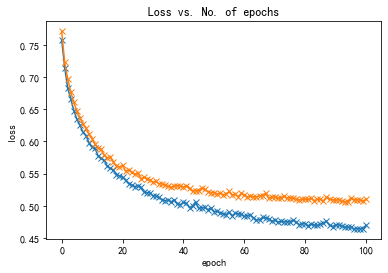

In [31]:
train_losses = [float(x['epoch_loss']) for x in history_train]
val_losses = [float(x['epoch_loss']) for x in history_val]
plt.plot(train_losses, '-x', val_losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

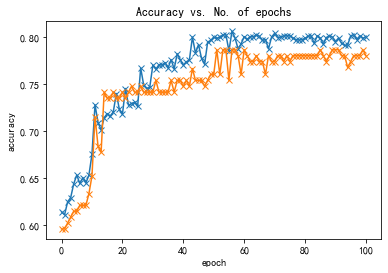

In [32]:
train_accs = [float(x['epoch_acc']) for x in history_train]
val_accs = [float(x['epoch_acc']) for x in history_val]
plt.plot(train_accs, '-x', val_accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

可以看到，模型在学习速率为0.005的情况下，训练到80步的时候，准确率在79%左右不再上升。

## 5. 小结

&ensp;&ensp;&ensp;&ensp;在这份报告中，我们使用Pytorch搭建逻辑回归模型进行了泰坦尼克号生存率预测。首先，我们分析并提炼了数据集的特征数据，在这个过程中，熟悉了pandas中的dataframe数据结构的基本操作，发现其在批量处理数据时十分方便，并将一些连续值的变量变成分段变量以提高数据的凝练度。此外，该任务中，由于样本中存在大量缺失值，所以还对如何处理缺失值进行了学习。